In [1]:
# Carregar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mlflow

In [2]:
# Carregar o dataset processado
raw_path = "../meu_projeto/data/raw/train.csv"

train_data = pd.read_csv(raw_path, 
                    header=None,
                    names=["rating", "review_title", "review_text"]
)

In [3]:
# Informações básicas
print("head")
display(train_data.head())

# Exibir informações sobre o dataset
print("info")
display(train_data.info())

# Exibir dimensões do dataset
print("shape")
display(train_data.shape)

# Exibir estatísticas básicas
print("describe")
display(train_data.describe())

# Verificar valores ausentes
print("valores ausentes")
display(train_data.isnull().sum().sort_values(ascending=False))

head


,rating,review_title,review_text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   rating        int64 
 1   review_title  object
 2   review_text   object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


None

shape


(3600000, 3)

describe


,rating
count,3600000.0
mean,1.5
std,0.5
min,1.0
25%,1.0
50%,1.5
75%,2.0
max,2.0


valores ausentes


review_title    207
rating            0
review_text       0
dtype: int64

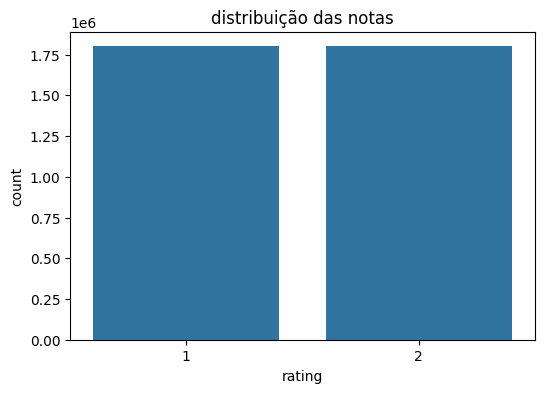

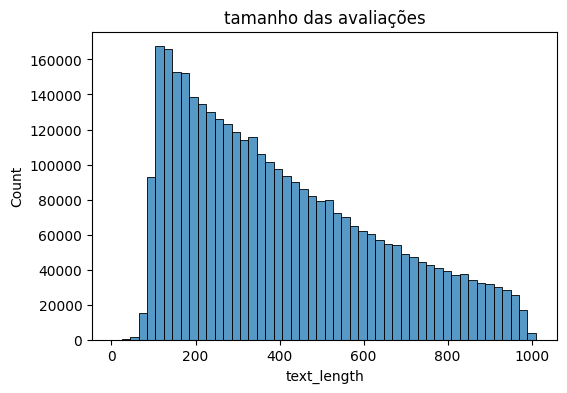

In [4]:
os.makedirs("data/reports", exist_ok=True)

# Distribuição de notas
plt.figure(figsize=(6,4))
sns.countplot(x=train_data["rating"])
plt.title("distribuição das notas")
plt.savefig("../meu_projeto/data/reports/distribuicao_notas.png")
plt.show()

# Tamanho dos textos
train_data["text_length"] = train_data["review_text"].astype(str).apply(len)
plt.figure(figsize=(6,4))
sns.histplot(train_data["text_length"], bins=50)
plt.savefig("../meu_projeto/data/reports/distribuicao_tamanho_avaliacoes.png")
plt.title("tamanho das avaliações")
plt.show()

In [5]:
# O dataset é muito grande
# O dataset está balanceado entre avaliações positivas e negativas
# A maioria das avaliações tem entre 150 e 300 caracteres
# A avaliação é positiva se está o valor 2 na coluna e negativa se está o valor 1
# O dataset tem valores nulos apenas no campo título

In [6]:
# Limpeza e tratamento de Dados
clean_data = train_data.copy()

# Remover duplicatas
before = clean_data.shape[0]
clean_data.drop_duplicates(inplace=True)
after = clean_data.shape[0]
print(f'Duplicatas removidas: {before - after}')

cat_cols = clean_data.select_dtypes(include=['object', 'category', 'bool']).columns
for c in cat_cols:
    clean_data[c] = clean_data[c].fillna('Desconhecido')

print('Valores ausentes restantes (depois da imputação):')
display(clean_data.isnull().sum().sort_values(ascending=False).head(10))

Duplicatas removidas: 0
Valores ausentes restantes (depois da imputação):


rating          0
review_title    0
review_text     0
text_length     0
dtype: int64

In [7]:
# Transformar avaliações 1/2 em 0/1
clean_data["labels"] = clean_data["rating"].apply(lambda x: 1 if x == 2 else 0)

# Definir tamanho da amostra por classe
samples_per_class = 15000

# Separar por classe
positive_reviews = clean_data[clean_data["labels"] == 1].sample(samples_per_class, random_state=42)
negative_reviews = clean_data[clean_data["labels"] == 0].sample(samples_per_class, random_state=42)

# Juntar e embaralhar
balanced_train_data = pd.concat([positive_reviews, negative_reviews]).sample(frac=1, random_state=42)

# Amostra
balanced_train_data[["labels","review_text"]].sample(10)

,labels,review_text
1668247,0,Don't bother with this DVD. Another DVD is ava...
1534176,1,"I have two schnauzers, one with soft curly hai..."
2318183,1,I have only been using this product for a litt...
2847113,0,Although these shoe covers look like all the o...
2152126,0,Upon the recommendation of a physical therapis...
2466529,0,Please note that the Mac OS version requires u...
512924,0,"Well, Ms. Wurts kept me waiting an awfully lon..."
639479,0,"I have a sweet little cat, and you know what? ..."
2027091,1,I own about 3500 CD's in my collection and I w...
2519889,0,"This book started out steamy, but did not deli..."


In [8]:
# balanced_train_data = pd.concat([positive_reviews, negative_reviews]).sample(frac=1, random_state=42)
print(balanced_train_data.shape)

(30000, 5)


In [9]:
# Logar algumas métricas no MLFlow

# Configura MLFlow
MLFLOW_TRACKING_URI = "http://localhost:8080"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("project_amazon_reviews")

counts = balanced_train_data["labels"].value_counts()
print("counts per labels:\n", counts)
rawRows = len(pd.read_csv(raw_path))
print("counts per labels:\n", counts)
rowsAfterFilter = len(balanced_train_data)
print("counts per labels:\n", counts)

os.makedirs("data/processed", exist_ok=True)
sample_path = "data/processed"

with mlflow.start_run(run_name="eda"):
    mlflow.log_param("raw_rows", rawRows)
    mlflow.log_param("rows_after_filter", rowsAfterFilter)
    mlflow.log_param("labels_0_count", int(counts.get(0)))
    mlflow.log_param("labels_1_count", int(counts.get(1)))
    mlflow.log_artifact("../meu_projeto/data/reports/distribuicao_notas.png")
    mlflow.log_artifact("../meu_projeto/data/reports/distribuicao_tamanho_avaliacoes.png")


counts per labels:
 labels
1    15000
0    15000
Name: count, dtype: int64
counts per labels:
 labels
1    15000
0    15000
Name: count, dtype: int64
counts per labels:
 labels
1    15000
0    15000
Name: count, dtype: int64
🏃 View run eda at: http://localhost:8080/#/experiments/904744022373053032/runs/dc5ef3ed34e543879ac9dd6b2aefbf80
🧪 View experiment at: http://localhost:8080/#/experiments/904744022373053032


In [10]:
# Salvar o dataset
# salvar em parquet para carregar mais rápido depois para a etapa de treino
os.makedirs("data/processed", exist_ok=True)
balanced_train_data.to_parquet("../meu_projeto/data/processed/amazon_reviews_train_sample.parquet")

In [11]:
# Carregar test
test_data = pd.read_csv("../meu_projeto/data/raw/test.csv", 
                         header=None, 
                         names=["rating", "review_title", "review_text"]
)

# Informações básicas
print("head")
display(test_data.head())

# Exibir informações sobre o dataset
print("info")
display(test_data.info())

# Exibir dimensões do dataset
print("shape")
display(test_data.shape)

# Exibir estatísticas básicas
print("describe")
display(test_data.describe())

# Verificar valores ausentes
print("valores ausentes")
display(test_data.isnull().sum().sort_values(ascending=False))

test_data["labels"] = test_data["rating"].apply(lambda x: 1 if x == 2 else 0)

# Salvar como parquet
test_data.to_parquet("../meu_projeto/data/processed/amazon_reviews_test_sample.parquet")

head


,rating,review_title,review_text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   rating        400000 non-null  int64 
 1   review_title  399976 non-null  object
 2   review_text   400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


None

shape


(400000, 3)

describe


,rating
count,400000.000000
mean,1.500000
std,0.500001
min,1.000000
25%,1.000000
50%,1.500000
75%,2.000000
max,2.000000


valores ausentes


review_title    24
rating           0
review_text      0
dtype: int64